<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/EVA6S11_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Sun Aug  1 17:52:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys

Mounted at /content/drive


### Dependencies


In [6]:
!cp -Rf /content/drive/MyDrive/EVA6/S11/YoloV3_pre /content

In [8]:
%cd /content/YoloV3_pre


/content/YoloV3_pre


In [9]:
%cd /content/YoloV3_pre
!wget https://pjreddie.com/media/files/yolov3.weights

/content/YoloV3_pre
--2021-08-01 17:55:43--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  64.3MB/s    in 3.9s    

2021-08-01 17:55:47 (60.5 MB/s) - ‘yolov3.weights.1’ saved [248007048/248007048]



In [10]:
%cd /content/YoloV3_pre
!python yolo_object_detection.py

/content/YoloV3_pre
./yolov3.weights ./yolov3.cfg ./coco.names
[[0]
 [4]
 [5]
 [6]
 [1]
 [3]]
: cannot connect to X server 


In [1]:
import cv2
import numpy as np
import os

In [5]:

def generate_bounding_box_preds(base_path, src_file):

    weights_file = os.path.join(base_path,"yolov3.weights")
    cfg_file = os.path.join(base_path,"yolov3.cfg")
    coconames_file  = os.path.join(base_path,"coco.names")
    print(weights_file, cfg_file, coconames_file)

    net = cv2.dnn.readNet(weights_file, cfg_file)
    classes = []
    with open(coconames_file, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))

    # Loading image
    img_filename = src_file
    img = cv2.imread(img_filename)
    img = cv2.resize(img, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape

    # Detecting objects
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    net.setInput(blob)
    outs = net.forward(output_layers)
    return outs

In [11]:
def generated_annotated_image(base_path: "str", 
                              outs: "Bounding Boxes List",
                              src_image: str, 
                              annotated_img_path: str):
    # Showing informations on the screen
    class_ids = []
    confidences = []
    boxes = []
    img = cv2.imread(src_image)
    img = cv2.resize(img, None, fx=0.4, fy=0.4)   
    height, width, channels = img.shape
    classes = []
    coconames_file = os.path.join(base_path,"coco.names")
    
    with open(coconames_file, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    print(indexes)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[i]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y + 30), font, 3, color, 3)
    cv2.imwrite(annotated_img_path, img)

In [18]:
base_path = "/content/YoloV3_pre"

src_file_name = "/content/YoloV3_pre/discussion-restaurant-business-coffee-shop.jpg"
output_filename = "/content/YoloV3_pre/Annotated_output.JPG"
out_bbox = generate_bounding_box_preds(base_path, src_file_name)
generated_annotated_image(base_path, out_bbox,src_file_name, output_filename)

/content/YoloV3_pre/yolov3.weights /content/YoloV3_pre/yolov3.cfg /content/YoloV3_pre/coco.names
[[1]
 [0]
 [2]
 [4]
 [3]]


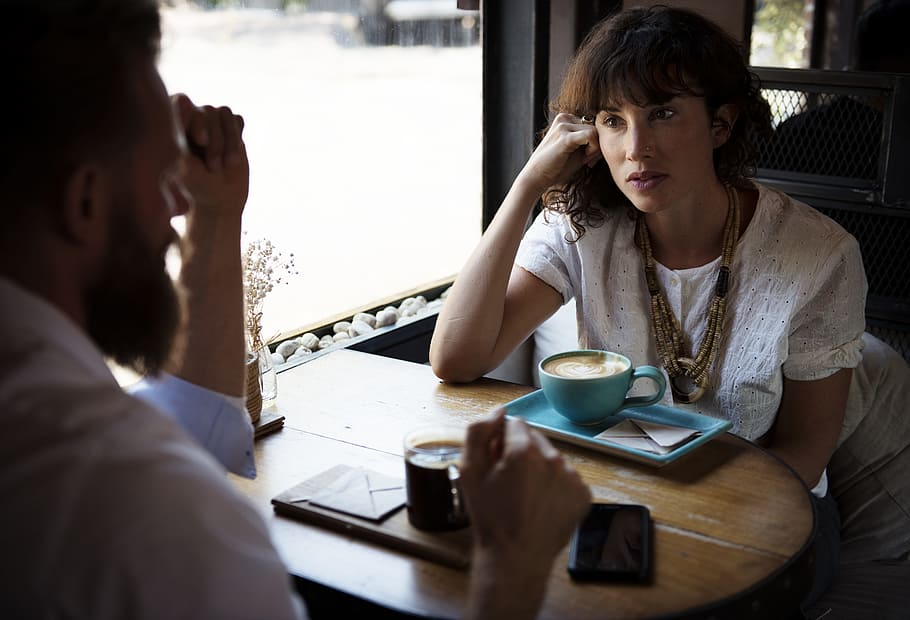

In [19]:
from IPython.display import Image, clear_output 
Image(filename=src_file_name, width=600)

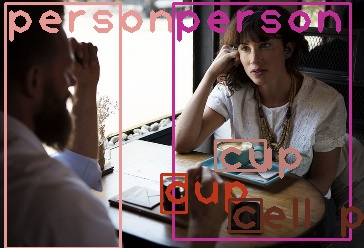

In [20]:

Image(filename=output_filename, width=600)